In [1]:
import os
if "py" not in os.listdir("."):
    os.chdir("..")
    
%config Completer.use_jedi = False

In [2]:
import microdf as mdf
import numpy as np
import openfisca_uk as o
import pandas as pd
from openfisca_uk import IndividualSim, PopulationSim
from openfisca_uk.reforms.modelling import reported_benefits
from py.calc_ubi import ubi_reform
import ubicenter

REGION_CODES = [
    "NORTH_EAST",
    "NORTH_WEST",
    "YORKSHIRE",
    "EAST_MIDLANDS",
    "WEST_MIDLANDS",
    "EAST_OF_ENGLAND",
    "LONDON",
    "SOUTH_EAST",
    "SOUTH_WEST",
    "WALES",
    "SCOTLAND",
    "NORTHERN_IRELAND",
]

REGION_NAMES = [
    "North East",
    "North West",
    "Yorkshire and the Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East",
    "South West",
    "Wales",
    "Scotland",
    "Northern Ireland",
]

region_code_map = dict(zip(range(len(REGION_CODES)), REGION_CODES))
region_name_map = dict(zip(range(len(REGION_NAMES)), REGION_NAMES))

optimal_params = pd.read_csv("optimal_params.csv").round()  # Up a folder.


In [3]:
optimal_params

,adult,senior,child,dis_base,NORTH_EAST,NORTH_WEST,YORKSHIRE,EAST_MIDLANDS,WEST_MIDLANDS,EAST_OF_ENGLAND,LONDON,SOUTH_EAST,SOUTH_WEST,WALES,SCOTLAND,NORTHERN_IRELAND,mean_pct_loss
0,124.0,207.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,119.0,197.0,76.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,115.0,192.0,72.0,74.0,6.0,6.0,0.0,4.0,4.0,2.0,8.0,4.0,5.0,3.0,5.0,4.0,0.0


In [4]:
import microdf as mdf
import numpy as np
import openfisca_uk as o
import pandas as pd
from openfisca_uk import IndividualSim, PopulationSim
from openfisca_uk.reforms.modelling import reported_benefits
from py.calc_ubi import ubi_reform

REGION_CODES = [
    "NORTH_EAST",
    "NORTH_WEST",
    "YORKSHIRE",
    "EAST_MIDLANDS",
    "WEST_MIDLANDS",
    "EAST_OF_ENGLAND",
    "LONDON",
    "SOUTH_EAST",
    "SOUTH_WEST",
    "WALES",
    "SCOTLAND",
    "NORTHERN_IRELAND",
]

REGION_NAMES = [
    "North East",
    "North West",
    "Yorkshire and the Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East",
    "South West",
    "Wales",
    "Scotland",
    "Northern Ireland",
]

region_code_map = dict(zip(range(len(REGION_CODES)), REGION_CODES))
region_name_map = dict(zip(range(len(REGION_NAMES)), REGION_NAMES))

optimal_params = pd.read_csv("optimal_params.csv")  # Up a folder.


def reform(i):
    row = optimal_params.iloc[i].round()
    return ubi_reform(
        adult=row.adult,
        child=row.child,
        senior=row.senior,
        dis_base=row.dis_base,
        geo=row[REGION_CODES],
    )


reforms = [reform(i) for i in range(3)]

baseline_sim = PopulationSim(reported_benefits)
reform_sims = [PopulationSim(reported_benefits, reform) for reform in reforms]

REFORM_NAMES = ["1: Foundational", "2: Disability", "3: Disability + geo"]

BASELINE_PERSON_COLS = [
    "household_weight",
    "age",
    "region",
    "is_disabled_for_ubi",
]

# Extract these for baseline too.
REFORM_PERSON_COLS = [
    "household_net_income",
    "in_poverty_bhc",
    "in_deep_poverty_bhc",
]

BASELINE_HH_COLS = ["household_weight", "people_in_household", "region"]

# Extract these for baseline too.
REFORM_HH_COLS = [
    "household_net_income",
    "equiv_household_net_income",
    "poverty_gap_bhc",
    "poverty_gap_ahc",
]

p_base = mdf.MicroDataFrame(
    baseline_sim.df(
        BASELINE_PERSON_COLS + REFORM_PERSON_COLS, map_to="person"
    ),
    weights="household_weight",
)
p_base.rename(
    dict(zip(REFORM_PERSON_COLS, [i + "_base" for i in REFORM_PERSON_COLS])),
    axis=1,
    inplace=True,
)

hh_base = mdf.MicroDataFrame(
    baseline_sim.df(BASELINE_HH_COLS + REFORM_HH_COLS, map_to="household"),
    weights="household_weight",
)
hh_base.rename(
    dict(zip(REFORM_HH_COLS, [i + "_base" for i in REFORM_HH_COLS])),
    axis=1,
    inplace=True,
)
hh_base["person_weight"] = (
    hh_base.household_weight * hh_base.people_in_household
)

# # Add region code and names
# hh_base["region_code"] = hh_base.region.map(region_code_map)
# hh_base["region_name"] = hh_base.region.map(region_name_map)
# p_base["region_code"] = p_base.region.map(region_code_map)
# p_base["region_name"] = p_base.region.map(region_name_map)

# Change weight column to represent people for decile groups.
hh_base.set_weights(hh_base.person_weight)
hh_base["decile"] = np.ceil(
    hh_base.equiv_household_net_income_base.rank(pct=True) * 10
)

# Change weight back to household weight for correct calculation of totals.
hh_base.set_weights(hh_base.household_weight)


def reform_p(i):
    p = reform_sims[i].df(REFORM_PERSON_COLS, map_to="person")
    p["reform"] = REFORM_NAMES[i]
    return mdf.concat([p_base, p], axis=1)


def reform_hh(i):
    hh = reform_sims[i].df(REFORM_HH_COLS, map_to="household")
    hh["reform"] = REFORM_NAMES[i]
    return mdf.concat([hh_base, hh], axis=1)


def pct_chg(base, new):
    return (new - base) / base


def reform_stats(df):
    # For applying over a groupby(reform) or a .
    gini = df.equiv_household_net_income_base.aggregate(
        ["gini", "top_10pct_share"]
    )
    p_agg = df[["household_net_income_pl", "winner"]].mean()



p = mdf.concat([reform_p(i) for i in range(3)])
h = mdf.concat([reform_hh(i) for i in range(3)])

p = p.reset_index(drop=True)#.drop("index", axis=1)
h = h.reset_index(drop=True)#.drop("index", axis=1)

def chg(df, col):
    df[col + "_chg"] = df[col] - df[col + "_base"]
    # Percentage change, only defined for positive baselines.
    df[col + "_pc"] = np.where(
        df[col + "_base"] > 0,
        df[col + "_chg"] / df[col + "_base"],
        np.nan,
    )
    # Percentage loss. NB: np.minimum(np.nan, 0) -> np.nan.
    df[col + "_pl"] = np.minimum(0, df[col + "_pc"])

chg(p, "household_net_income")
chg(h, "household_net_income")
p["winner"] = p.household_net_income_chg > 0
h["winner"] = h.household_net_income_chg > 0
# Per-reform.
INEQS = ["gini", "top_10_pct_share", "top_1_pct_share"]
ineq_base = h.groupby("reform").equiv_household_net_income_base.agg(INEQS)
ineq_base.columns = [i + "_base" for i in ineq_base.columns]
ineq_reform = h.groupby("reform").equiv_household_net_income.agg(INEQS)
ineq_reform.columns = [i + "_reform" for i in ineq_reform.columns]
p_agg = p.groupby("reform")[["household_net_income_pl", "winner"]].mean()
r = p_agg.join(ineq_base).join(ineq_reform, on="reform")
r["reform"] = r.index  # Easier for plotting.
for i in INEQS:
    r[i + "_pc"] = pct_chg(r[i + "_base"], r[i + "_reform"])

# Per reform per decile (by household).

decile = (
    h.groupby(["reform", "decile"])
    .sum()[
        [
            "household_net_income",
            "household_net_income_base",
            "people_in_household",
        ]
    ]
    .reset_index()
)
decile["chg"] = (
    decile.household_net_income - decile.household_net_income_base
)
decile["chg_pp"] = decile.chg / decile.people_in_household
decile["pc"] = decile.chg / decile.household_net_income_base
# return p, h, r, decile

TypeError: reset_index() got an unexpected keyword argument 'drop'

In [18]:
p_base["age_0_17"] = p_base.age < 18
p_base["age_18_64"] = p_base.age.between(18, 64)
p_base["age_65"] = p_base.age > 64
p_base[["age_0_17", "age_18_64", "age_65", "is_disabled_for_ubi"]].sum()

age_0_17               13721411.0
age_18_64              39986887.0
age_65                 11770257.0
is_disabled_for_ubi     4018390.0
dtype: float64

Housing costs and income.

In [95]:
housing = mdf.MicroDataFrame(baseline_sim.df(["housing_costs", "household_net_income", "tenure_type", "household_weight"],
                                             map_to="household"),
                             weights="household_weight")

VariableNotFound: You tried to calculate or to set a value for variable 'tenure_type', but it was not found in the loaded tax and benefit system (openfisca-uk@0.2.2).
Are you sure you spelled 'tenure_type' correctly?
If this code used to work and suddenly does not, this is most probably linked to an update of the tax and benefit system.
Look at its changelog to learn about renames and removals and update your code. If it is an official package,
it is probably available on <https://github.com/openfisca/openfisca-uk/blob/master/CHANGELOG.md>.

In [50]:
housing.housing_costs.describe()

count    2.782879e+07
mean     4.194234e+03
std      5.371011e+03
min      0.000000e+00
25%      6.760000e+02
50%      3.120000e+03
75%      5.824000e+03
max      4.790760e+05
Name: housing_costs, dtype: float64

In [44]:
housing.sort_values("housing_costs")

,housing_costs,household_net_income,household_weight
9878,0.0,14196.000000,434.0
15166,0.0,28219.250000,1488.0
164,0.0,22193.130859,606.0
1948,0.0,28766.449219,304.0
11528,0.0,13260.000000,281.0
...,...,...,...
1925,56836.0,100524.617188,2061.0
7966,58344.0,73415.773438,2233.0
15464,59072.0,66220.328125,1541.0
13300,60112.0,71889.921875,2013.0


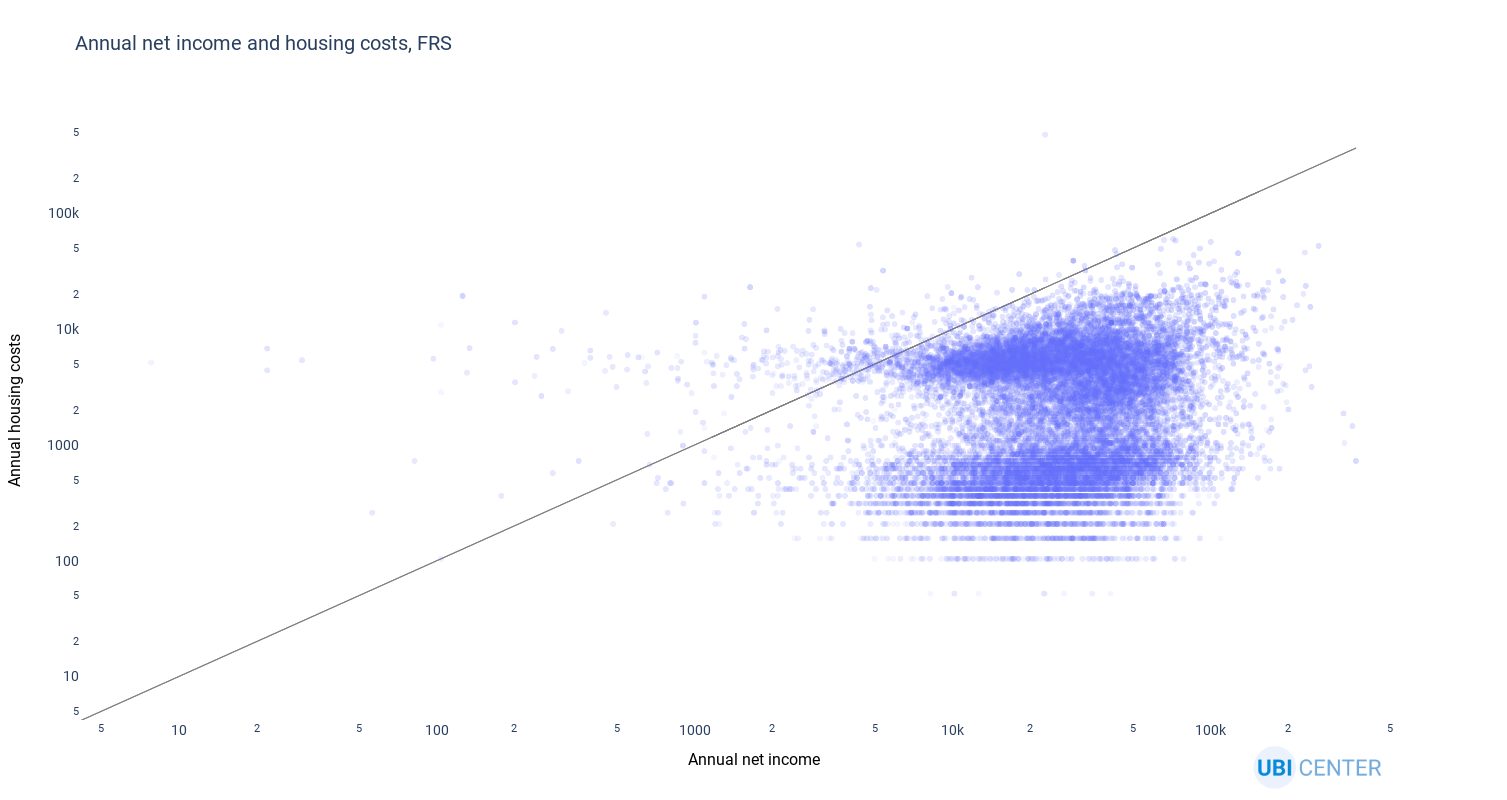

In [81]:
import plotly.express as px
import plotly.graph_objects as go
import ubicenter
fig = px.scatter(housing, "household_net_income", "housing_costs", log_x=True, log_y=True,
                 labels={"housing_costs": "Annual housing costs", "household_net_income": "Annual net income"},
                 title="Annual net income and housing costs, FRS", opacity=np.sqrt(housing.household_weight) / np.sqrt(housing.household_weight).max())
fig.add_trace(go.Scatter(x=housing.household_net_income, y=housing.household_net_income, line=dict(color='gray', width=1)))
fig.update_layout(showlegend=False)
ubicenter.format_fig(fig)

In [82]:
housing["housing_exceeds_income"] = housing.housing_costs > housing.household_net_income
housing.housing_exceeds_income.mean()

0.04557945698459656

In [94]:
housing["i"] = 1
housing[housing.housing_costs > 30000].i.sum() / housing.i.sum()

0.003715109824944939

In [90]:
from statsmodels.stats.weightstats import DescrStatsW

DescrStatsW(housing[["housing_costs", "household_net_income"]], housing.household_weight).corrcoef[0, 1]

0.13722007014405502

In [ ]:
from openfisca_uk import IndividualSim
import plotly.express as px

# define the simulation and populate it

sim = IndividualSim()
sim.add_person(name="individual1", age=70, state_pension=134.25*52, is_benunit_head=True)
sim.add_person(name="individual2", age=70, state_pension=134.25*52)
# Not necessary:
sim.add_benunit(adults=["individual1", "individual2"],
                pension_credit_reported=True)
sim.add_household(adults=["individual1", "individual2"])

# replicate the simulation along the earnings dimension
sim.vary("pension_income", index=0, min=0, max=20000, step=100)
sim.vary("pension_income", index=1, min=0, max=20000, step=100)

simr = IndividualSim(reforms[0])
simr.add_person(name="individual1", state_pension=134*52, age=70, is_benunit_head=True)
simr.add_person(name="individual2", state_pension=134*52, age=70)
# Not necessary:
simr.add_benunit(adults=["individual1", "individual2"],
                 pension_credit_reported=True)
simr.add_household(adults=["individual1", "individual2"])

# replicate the simulation along the earnings dimension

simr.vary("pension_income", index=0, min=0, max=20000, step=100)
simr.vary("pension_income", index=1, min=0, max=20000, step=100)

# retrieve the arrays of earnings and marginal tax rates
earnings = sim.calc("pension_income") * 2
net_income = sim.calc("household_net_income")[0]
net_income_r = simr.calc("household_net_income")[0]

# df = pd.DataFrame({})

# plot the results

fig = px.line(x=earnings[0], y=[net_income, net_income_r],
              title="Net income of married pensioner household")
fig.update_layout(yaxis_tickprefix="£", xaxis_tickprefix="£", 
                  xaxis_title="Pension income", yaxis_title="Net income")
ubicenter.format_fig(fig)

In [ ]:
LIGHT_BLUE = "#BBDEFB"  # Blue 100.
BLUE = "#1976D2"  # Blue 700.
DARK_BLUE = "#0D47A1"  # Blue 900.
RED = "#FF7043"  # Red 400.
DARK_RED = "#BF360C"  # Red 900.
GRAY = "#BDBDBD"  # Gray 400.
DARK_GRAY = "#757575"  # Gray 700.

COLOR_MAP = {"Baseline (no Universal Credit)": GRAY, "Baseline (Universal Credit)": DARK_GRAY, "UBI reform 1": BLUE}

In [ ]:
baseline_no_uc = IndividualSim()
baseline_uc = IndividualSim()
reform = IndividualSim(reforms[0])

for i, sim in enumerate([baseline_no_uc, baseline_uc, reform]):
    sim.add_person(name="a", age=30, is_benunit_head=True)
    if i == 0:  # No UC.
        sim.add_benunit(adults=["a"], universal_credit_reported=False)
    else:
        sim.add_benunit(adults=["a"], universal_credit_reported=True)
    sim.add_household(adults=["a"])
    sim.vary("earnings", min=0, max=100000, step=100)

df = pd.DataFrame(
    {
        "earnings": baseline_no_uc.calc("earnings")[0],
        "Baseline (no Universal Credit)": baseline_no_uc.calc("household_net_income")[
            0
        ],
        "Baseline (Universal Credit)": baseline_uc.calc("household_net_income")[0],
        "UBI reform 1": reform.calc("household_net_income")[0],
    }
)
df = df.melt(
    id_vars="earnings",
    value_vars=[
        "Baseline (no Universal Credit)",
        "Baseline (Universal Credit)",
        "UBI reform 1",
    ],
)
# plot the results

fig = px.line(
    df,
    "earnings",
    "value",
    color="variable",
    title="Net income of childless adult by earnings and reform",
    color_discrete_map=COLOR_MAP,
)
fig.update_layout(
    xaxis_tickprefix="£",
    xaxis_title="Annual earnings",
    yaxis_tickprefix="£",
    yaxis_title="Annual net income",
    legend_title="",
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.05,
    ),
)
ubicenter.format_fig(fig, x=1.05)

In [ ]:
baseline_no_uc = IndividualSim()
baseline_uc = IndividualSim()
reform = IndividualSim(reforms[0])

for i, sim in enumerate([baseline_no_uc, baseline_uc, reform]):
    sim.add_person(name="a", age=30, is_benunit_head=True)
    sim.add_person(name="c", age=10)
    if i == 0:  # No UC.
        sim.add_benunit(adults=["a"], children=["c"], universal_credit_reported=False)
    else:
        sim.add_benunit(adults=["a"], children=["c"], universal_credit_reported=True)
    sim.add_household(adults=["a"], children=["c"])
    sim.vary("earnings", min=0, max=100000, step=100)

df = pd.DataFrame(
    {
        "earnings": baseline_no_uc.calc("earnings")[0],
        "Baseline (no Universal Credit)": baseline_no_uc.calc("household_net_income")[
            0
        ],
        "Baseline (Universal Credit)": baseline_uc.calc("household_net_income")[0],
        "UBI reform 1": reform.calc("household_net_income")[0],
    }
)
df = df.melt(
    id_vars="earnings",
    value_vars=[
        "Baseline (no Universal Credit)",
        "Baseline (Universal Credit)",
        "UBI reform 1",
    ],
)
# plot the results

fig = px.line(
    df,
    "earnings",
    "value",
    color="variable",
    title="Net income of adult with one child by earnings and reform",
    color_discrete_map=COLOR_MAP,
)
fig.update_layout(
    xaxis_tickprefix="£",
    xaxis_title="Annual earnings",
    yaxis_tickprefix="£",
    yaxis_title="Annual net income",
    legend_title="",
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.05,
    ),
)
ubicenter.format_fig(fig, x=1.05)

In [ ]:
baseline_no_uc = IndividualSim()
baseline_uc = IndividualSim()
reform = IndividualSim(reforms[0])

for i, sim in enumerate([baseline_no_uc, baseline_uc, reform]):
    sim.add_person(name="a", age=30, is_benunit_head=True)
    sim.add_person(name="c", age=10)
    sim.add_person(name="d", age=10)
    if i == 0:  # No UC.
        sim.add_benunit(adults=["a"], children=["c", "d"], universal_credit_reported=False)
    else:
        sim.add_benunit(adults=["a"], children=["c", "d"], universal_credit_reported=True)
    sim.add_household(adults=["a"], children=["c", "d"])
    sim.vary("earnings", min=0, max=100000, step=100)

df = pd.DataFrame(
    {
        "earnings": baseline_no_uc.calc("earnings")[0],
        "Baseline (no Universal Credit)": baseline_no_uc.calc("household_net_income")[
            0
        ],
        "Baseline (Universal Credit)": baseline_uc.calc("household_net_income")[0],
        "UBI reform 1": reform.calc("household_net_income")[0],
    }
)
df = df.melt(
    id_vars="earnings",
    value_vars=[
        "Baseline (no Universal Credit)",
        "Baseline (Universal Credit)",
        "UBI reform 1",
    ],
)
# plot the results

fig = px.line(
    df,
    "earnings",
    "value",
    color="variable",
    title="Net income of single adult with two children by earnings and reform",
    color_discrete_map=COLOR_MAP,
)
fig.update_layout(
    xaxis_tickprefix="£",
    xaxis_title="Annual earnings",
    yaxis_tickprefix="£",
    yaxis_title="Annual net income",
    legend_title="",
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.05,
    ),
)
ubicenter.format_fig(fig, x=1.05)

In [ ]:
baseline_no_uc = IndividualSim()
baseline_uc = IndividualSim()
reform = IndividualSim(reforms[0])

for i, sim in enumerate([baseline_no_uc, baseline_uc, reform]):
    sim.add_person(name="a", age=30, is_benunit_head=True)
    sim.add_person(name="b", age=30)
    sim.add_person(name="c", age=10)
    sim.add_person(name="d", age=10)
    if i == 0:  # No UC.
        sim.add_benunit(adults=["a", "b"], children=["c", "d"], universal_credit_reported=False)
    else:
        sim.add_benunit(adults=["a", "b"], children=["c", "d"], universal_credit_reported=True)
    sim.add_household(adults=["a", "b"], children=["c", "d"])
    sim.vary("earnings", min=0, max=500000, step=100)

df = pd.DataFrame(
    {
        "earnings": baseline_no_uc.calc("earnings")[0],
        "Baseline (no Universal Credit)": baseline_no_uc.calc("household_net_income")[
            0
        ],
        "Baseline (Universal Credit)": baseline_uc.calc("household_net_income")[0],
        "UBI reform 1": reform.calc("household_net_income")[0],
    }
)
df = df.melt(
    id_vars="earnings",
    value_vars=[
        "Baseline (no Universal Credit)",
        "Baseline (Universal Credit)",
        "UBI reform 1",
    ],
)
# plot the results

fig = px.line(
    df,
    "earnings",
    "value",
    color="variable",
    title="Net income of married adult with two children by earnings and reform",
    color_discrete_map=COLOR_MAP,
)
fig.update_layout(
    xaxis_tickprefix="£",
    xaxis_title="Annual earnings (spouse has no earnings)",
    yaxis_tickprefix="£",
    yaxis_title="Annual net income",
    legend_title="",
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.05,
    ),
)
ubicenter.format_fig(fig, x=1.05)

In [ ]:
baseline_no_uc = IndividualSim()
baseline_uc = IndividualSim()
reform = IndividualSim(reforms[0])

for i, sim in enumerate([baseline_no_uc, baseline_uc, reform]):
    sim.add_person(name="a", age=70, state_pension=134.25*52, is_benunit_head=True)
    if i == 0:  # No UC.
        sim.add_benunit(adults=["a"], universal_credit_reported=False)
    else:
        sim.add_benunit(adults=["a"], universal_credit_reported=True)
    sim.add_household(adults=["a"])
    sim.vary("pension_income", min=0, max=100000, step=100)

df = pd.DataFrame(
    {
        "pension_income": baseline_no_uc.calc("pension_income")[0],
        "Baseline (no Universal Credit)": baseline_no_uc.calc("household_net_income")[
            0
        ],
        "Baseline (Universal Credit)": baseline_uc.calc("household_net_income")[0],
        "UBI reform 1": reform.calc("household_net_income")[0],
    }
)
df = df.melt(
    id_vars="pension_income",
    value_vars=[
        "Baseline (no Universal Credit)",
        "Baseline (Universal Credit)",
        "UBI reform 1",
    ],
)
# plot the results

fig = px.line(
    df,
    "pension_income",
    "value",
    color="variable",
    title="Net income of basic State Pension recipient by non-SP pension income and reform",
    color_discrete_map=COLOR_MAP,
)
fig.update_layout(
    xaxis_tickprefix="£",
    xaxis_title="Annual pension income, in addition to basic State Pension of £134.25/week",
    yaxis_tickprefix="£",
    yaxis_title="Annual net income",
    legend_title="",
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.05,
    ),
)
ubicenter.format_fig(fig, x=1.05)

In [ ]:
fig = px.line(x=earnings, y=net_income_r[0] / net_income[0], title="Net income diff")
fig.update_layout(
    yaxis_tickprefix="£",
    xaxis_tickprefix="£",
    xaxis_title="Earnings",
    yaxis_title="Net income",
)
fig.show()

In [ ]:
net_income[0]

In [ ]:
reforms[0]

In [ ]:
from openfisca_uk import IndividualSim
import plotly.express as px

# define the simulation and populate it

sim = IndividualSim(reforms[0])  # Doesn't work.
sim.add_person(name="individual", age=30, is_benunit_head=True)
sim.add_benunit(adults=["individual"], universal_credit_reported=True)
sim.add_household(adults=["individual"])

# replicate the simulation along the earnings dimension

sim.vary("earnings", min=0, max=200000, step=100)

# retrive the arrays of earnings and marginal tax rates

earnings = sim.calc("earnings", target="individual")
net_income2 = sim.calc("net_income", target="individual")

# plot the results

fig = px.line(x=earnings, y=net_income, title="Net income")
fig.update_layout(yaxis_tickprefix="£", xaxis_tickprefix="£", xaxis_title="Earnings", yaxis_title="Net income")
fig.show()

In [ ]:
from openfisca_uk import IndividualSim
import plotly.express as px

# define the simulation and populate it

sim = IndividualSim()
sim.add_person(name="individual", age=30, is_benunit_head=True)
sim.add_benunit(adults=["individual"], universal_credit_reported=True)
sim.add_household(adults=["individual"])

# replicate the simulation along the earnings dimension

sim.vary("earnings", min=0, max=200000, step=100)

# retrive the arrays of earnings and marginal tax rates

earnings = sim.calc("earnings", target="individual")
mtr = sim.calc_mtr(target="individual")

# plot the results

fig = px.line(x=earnings, y=mtr, title="Effective marginal tax schedule")
fig.update_layout(yaxis_tickformat="%", xaxis_tickprefix="£", xaxis_title="Earnings", yaxis_title="Marginal tax rate")
fig.show()

In [ ]:
from openfisca_uk import IndividualSim
import plotly.express as px

# define the simulation and populate it

sim = IndividualSim()
sim.add_person(name="parent", age=24, is_benunit_head=True)
sim.add_person(name="child", age=2)
sim.add_benunit(adults=["parent"], children=["child"], universal_credit_reported=True)
sim.add_household(adults=["parent"], children=["child"])

# replicate the simulation along the earnings dimension

sim.vary("earnings", min=0, max=200000, step=100)

# retrive the arrays of earnings and marginal tax rates

earnings = sim.calc("earnings", target="parent")
mtr = sim.calc_mtr(target="parent")

# plot the results

fig = px.line(x=earnings, y=mtr, title="Effective marginal tax schedule")
fig.update_layout(yaxis_tickformat="%", xaxis_tickprefix="£", xaxis_title="Earnings", yaxis_title="Marginal tax rate")
fig.show()

In [ ]:
h

In [ ]:
BUCKETS = ["Lose more than 5%", "Lose less than 5%", "Gain less than 5%", "Gain more than 5%"]
h["household_net_income_pc_group"] = pd.cut(h.household_net_income_pc, [-np.inf, -0.05, 0, 0.05, np.inf],
                                            labels=BUCKETS)

In [ ]:
def group(groupby, name="people_in_household"):
    return (
        h[h.household_net_income_base > 0].groupby(groupby)
        .people_in_household.sum()
        .reset_index()
        .rename({0: name}, axis=1)
    )


chg_bucket = group(["reform", "decile", "household_net_income_pc_group"])
chg_bucket_decile_total = group(["reform", "decile"], "total_people_in_household")
chg_bucket_total = group(["reform", "household_net_income_pc_group"])
reform_total = group("reform")
# Calculate share of decile.
chg_bucket = chg_bucket.merge(chg_bucket_decile_total, on=["reform", "decile"])
chg_bucket["share_of_decile"] = chg_bucket.people_in_household / chg_bucket.total_people_in_household

# Sort for correct stack order.
chg_bucket["order"] = chg_bucket.household_net_income_pc_group.map(dict(zip(BUCKETS, range(len(BUCKETS)))))
chg_bucket.sort_values("order", ascending=False, inplace=True)
chg_bucket

In [ ]:
chg_bucket1 = chg_bucket[chg_bucket.reform == "1: Foundational"]
WITHIN_COLORS = [
    "#c56000",  # Medium amber.
    "#ffc046",  # Light amber.
    "#63a4ff",  # Light blue.
    "#004ba0",  # Dark blue.
]
WITHIN_COLOR_MAP = dict(zip(BUCKETS, WITHIN_COLORS))

In [ ]:
import plotly.express as px
fig = px.bar(chg_bucket1, "share_of_decile", "decile", color="household_net_income_pc_group", orientation="h", color_discrete_map=WITHIN_COLOR_MAP)
fig.update_layout(title="Distribution of impacts within deciles", yaxis_dtick=1, legend_title="", xaxis_tickformat="%", xaxis_title="Population share of decile", yaxis_title="Person-weighted decile of baseline household equivalized income")
import ubicenter
def ubi_chart(fig, name):
    fig = ubicenter.format_fig(fig, show=False)
    fig.write_image(f"images/{name}.png", scale=2)
    ubicenter.format_fig(fig)
ubi_chart(fig, "dist1")

In [ ]:
h.reset_index().drop("index", axis=1).__class__

In [ ]:
h.groupby("reform").equiv_household_net_income_base.mean()

In [ ]:
h[["people_in_household"]].sum()

In [ ]:
h.groupby("decile").sum()

In [ ]:
h.reform.rank()

In [ ]:
d = mdf.MicroDataFrame({"x": [1, 2, 3]}, index=[1, 1, 2], weights=pd.Series([4, 5, 6], index=[1, 1, 2]))

In [ ]:
d.gini()

In [ ]:
h = h.reset_index().drop("index", axis=1)

In [ ]:
h.index

In [ ]:
h[h.household_net_income_base > 0][["reform", "decile", "household_net_income_base", "household_net_income", "household_weight"]].groupby("reform").sum()

In [ ]:
h[h.household_net_income_base > 0][["reform", "decile", "household_net_income_base", "household_net_income", "household_weight"]].groupby(["reform", "decile"]).sum()

In [ ]:
decile = (
        # Remove non-positive income, for whom income change is unhelpful.
        h[h.household_net_income_base > 0]
        .groupby(["reform", "decile"])[
            [
                "household_net_income_base",
                "household_net_income",
                "household_weight",
            ]
        ]
        .sum()
        .reset_index()
    )
decile["chg"] = (
    decile.household_net_income - decile.household_net_income_base
)
decile["chg_per_hh"] = decile.chg / decile.household_weight
decile["pc"] = decile.chg / decile.household_net_income_base

In [ ]:
pd.DataFrame(hh_base).groupby("decile").person_weight.sum()

In [ ]:
hh_base.equiv_household_net_income_base < (295 * 52)

In [ ]:
((hh_base.equiv_household_net_income_base < (295 * 52)) != hh_base.in_poverty_bhc).mean()

In [ ]:
(hh_base.equiv_household_net_income_base < hh_base.poverty_line_bhc) != hh_base.in_poverty_bhc

In [ ]:
o.tools.aggregates.poverty_rate(baseline_sim)